In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
%%latex
\newcommand{\matr}[1]\textbf{#1}
\newcommand{\vect}[1]{\vec{#1}}
\usepackage[table,xcdraw]{xcolor}

<IPython.core.display.Latex object>

# To my dear supervisors

Dear Professor Likos!
Dear Dr. Bianchi!

Professor Likos, I hope you're enjoying your vacation.

You haven't heard from me in a while because I was on vaction too, but I have started my work on the thesis. 
I will review what we discussed in person and online with Dr. Bianchi, and I hope you are as interested in the
research question as I am. Dr. Bianchi, if you have suggestions for adapting dimensions/parameters of the situation (fluid flow through 2d cross section of pipe with cylindrical obstacles) or even tweak the situation, I would love to hear your suggestions too.
I hope I depicted the situation somewhat well below. I thought it would be interesting to not only try obstacles that are
regularly spaced, all the same size, but try a more heterogeneous situation. But that is still a little ways down the road,
so I'll have to see about that.

Progress-wise I'd say I'm still at the beginning. All the work here has been done in about 1 week. I'm working on the collision step now. It took a lot of time to get familiar with C++ again, and to find out how best to test my results. I think I have found a good way to do this, called unit testing, which basically means you test every unit of your program separately and make sure they work under various circumstances, to make debugging easier later down the road and also to add more credibility to my results.

Please do not worry if the writing style is sometimes informal, and at other times formal. I meant it to be that way, as some sections are unfinished/jumbled down thoughts/still expanding/experimenting. Also, the citing style is not the final version either, unfortunately, I cannot change it at the moment.

I'd be happy to hear your guidance and if everything is looking good, or if you suggest I focus more on other areas. If you have a lot to tell me I'd be happy to meet over Zoom/Teams or in person.

Where possible, I've not cited Wikipedia, or added other sources. Is it still okay if I cite Wikipedia, or is that completely undesirable?

All the best,

Chris

# MPCD simulation of polymers in solution

This notebook will serve as the documentation of our efforts and results for my Bachelor's Thesis. The goal of this thesis will be the study of short/long-chained polymers in a liquid thats flowing around obstacles. The liquid will be simulated with MPCD, or "Multi Particle Collision Dynamics".

I chose the language C++ for its familiar object-oriented nature and its proven execution-time. Output of the simulation will mostly be analysed in Python, specifically with Jupyter Notebook for a blend of beautiful visualizations and convenience. For simplification, the situation will be studied in 2D. The situation we specifically discussed is shown below.

![Situation](Assets/MPCD_Situation.png)

### Open questions & Description of situation

For these questions, I need to expand the program to even consider them. If I get close and still have no idea how to go about them, I will contact Maximilian Liebetreu (I think he was there when we first met, I'm sorry I can't remember exactly). Are there other people I can contact for the programming/implementation details?

The fluid flows from the -x direction through the 2D cross-section of some vessel. In this vessel there are cylindrically shaped objects, through which the fluid cannot pass. (->How will I simulate the obstacles, are they solid non-deformable, are they soft & elastic, ..?) (-> Methods: create a lot of particles and immobilize them?, check for collision between particles and obstacles on a per particle basis? (this will probably be too expensive computationally))

What happens when fluid goes out of bounds? (->Should particles that go too far in the +x direction be destroyed and new ones created from the -x direction, simulating continuous flow?)

Finally, polymers will be introduced into the fluid and their behavior studied. We might imagine this "vessel" as a blood vessel and the obstacles as cells moving around in the bloodstream, for example. (-> For the polymers, you told me I should wait until the MPCD is really working)

# Introduction

Multiparticle collision dynamics (MPCD), also known as Stochastic Rotation Dynamics (SRD)[@winkl2009] is a technique originally introduced to study the dynamics of complex fluids such as polymers in solution. Besides MPCD, there exist other mesoscopic models that have been constructed for this purpose, such as Langevin, Direct Simulation Monte Carlo and lattice Boltzmann methods.[@malev1999] We only concern ourselves with the application of MPCD, it follows that any comparison between methods are out of the scope of this thesis.

The MPCD technique models the fluid using particles, their positions and velocities are treated as continuous variables. The system is divided up into cells that have no restriction on the number of particles, each of the cells is part of a regular lattice. The dynamics is split into two parts: Particle streaming and multiparticle collision dynamics. Particle streaming is treated exactly for each particle in the system, while the collision step is approximated on a cell level. The multiparticle collision dynamics conserves mass, momentum and energy and leads to the correct hydrodynamical equations.[@malev1999] The streaming and collision step are described in more detail in (TODO: section numbering).

# The MPCD algorithm

The system we are modelling consists of $N$ particles with mass $m$, continuous position $\vec{r_{i}}$ and velocity $\vec{v_{i}}$, where $i \in \{1, 2, \dots, N\}$. One timestep $\Delta t$ shall correspond to having calculated all the new particle positions and velocities in the streaming and collision steps, respectively. For each of the $N$ particles, the streaming and collision steps are applied, and this pattern is repeated until the wanted number of timesteps have elapsed.

## The streaming step

The streaming step is very straightforward. The particle positions are simply updated according to

\begin{equation}
\vect{r_{i}} \rightarrow \vect{r_{i}} + \Delta t \cdot \vect{v_{i}}\textrm{,}
\end{equation}

where $\Delta t$ is a small time interval.[@winkl2009][@malev1999]

## The collision step

The collision step is somewhat more complicated. It involves the mean velocity of all particles in a particular cell, $\vect{V_c}$, the velocity of the particle $i$, $\vec{v_i}$, and a rotation matrix $\matr{R}(\alpha)$. The vector $\vect{v_i}$ is rotated relative to the mean velocity $\vect{V_c}$ of all particles in cell $c$, cell $c$ being the cell which particle $i$ belongs to. It is shown in [@malev1999] that the rule,

\begin{equation}
\vect{v_i} \rightarrow \vect{V_c} + \matr{R}(\alpha) [\vect{v_i} - \vect{V_c}] \textrm{,}
\end{equation}

conserves mass, momentum and energy under the molecular chaos assumption[@malev1999][@winkl2009, molecular chaos, p.7]. The rotation matrix $\matr{R}(\alpha)$ is a simple 2d rotation matrix

\begin{equation}
R(\alpha) = 
\left[ \begin{array}{rr}
cos(\alpha) & -sin(\alpha) \\
sin(\alpha) & cos(\alpha) \\
\end{array}\right],
\end{equation}

where $\alpha$ is sampled randomly on a per-cell basis. Furthermore, for each particle in the cell $\alpha$ flips its sign with probability $\frac{1}{2}$.[@winkl2009, (p.6)]
The mean velocity of a cell is defined as

\begin{equation}
\vect{V_c} = \frac{1}{N_c} \sum_{i=1}^{N_c} \vect{v_i} \textrm{,}
\end{equation}

where $N_c$ is the number of particles in cell c.[@malev1999]

The original MPCD algorithm was not Galilean invariant. The problem lay in the "molecular chaos" assumption, which means that particles involved in a collision have no memory of earlier encounters when colliding. This assumption is problematic when the mean free path 

\begin{equation}
\lambda = \Delta t \sqrt{\frac{k_{B}T}{m}}
\end{equation}

is small compared to the cell size $a$, since the same particles collide with each other repeatedly and thus build up correlations. When $\lambda \gg a$ Ihle and Kroll have shown that the molecular chaos assumption holds and the simulated results deviate from experimental ones only negligibly.[@ihlekroll2001, p.2][@winkl2009]

The solution to this problem is to shift all particles by the same random vector $s$ before the collision step. The components of $s$ are sampled randomly from a uniform distribution in the interval $[-\frac{a}{2}, \frac{a}{2}]$. After the collision, the particles are shifted back by the same amount.[@ihlekroll2001]

# Implementing the MPCD Algorithm

## (Pseudo) Random Number Generation

One of the pillars of this thesis is the generation of random rotation angles for the rotation matrix needed in the collision step. This proved to be somewhat difficult. First, the standard algorithm of the C++ standard library was tried, but it didn't qualify because it performed poorly in comparison to the second and third algorithms tried, which are called "Mersenne Twister" and "xoshiro256++", respectively.[@wiki:mersennetwister][@cppreference:prng][@unimi:xoshiro]

The Mersenne Twister was implemented using the C++ standard library. The xoshiro256++ was implemented using Sebastian Vigna's code with some additions.[@unimi:xoshiro]

To compare algorithms, and also to make sure that the implementation of the xoshiro256++ is right, a $\chi^2$ test for discrete observations was used. The generated angles in the interval $[0, 2\pi)$ were split into $k+1$ buckets, where $k$ is the number of degrees of freedom of the $\chi^2$ distribution. The test error

\begin{equation}
T = \sum_{b=1}^{k+1}{\frac{(N_o - E[N_b])^2}{E[N_b]}},
\end{equation}

where $E[N_b] = \frac{N}{b}, b \in \{1, 2, \dots , k+1\}$ is the expected bucket size, is compared to $\chi^2_{1-\alpha, k}$, where $\alpha$ is the signifigance level. The null hypothesis

$$
H_0: \textrm{The angles are distributed uniformly in the interval } [0, 2 \pi)
$$

is tested against the alternative hypothesis

$$
H_1: \textrm{The angles are not distributed uniformly in the interval } [0, 2 \pi) \textrm{.}
$$

If the test should have significance level $\alpha$, $H_0$ is rejected if $T \ge \chi^2_{1-\alpha, k}$.[@fruehwirthstat][@wiki:chisquaredtest][@wiki:goodnessoffit]

The results of the $\chi^2$ test are summarised in [TODO: Table, and table formatting].

In [3]:
path = "../x64/Debug/Data/RNG/"
mersenne = "mersenne_twister_chi2.csv"
xoshiro = "xoshiro_chi2.csv"
index = ["k", "chi^2 probability"]
out_path = "Generated/"
new_name = "chi2_results_dirty.csv"
mersenne_twister_chi2 = pd.read_csv(path + mersenne).set_index(index)
xoshiro256plusplus_chi2 = pd.read_csv(path + xoshiro).set_index(index)
results = mersenne_twister_chi2.join(xoshiro256plusplus_chi2, on = index, how = "inner")
results_csv = results.to_csv(out_path + new_name)

In [4]:
%%latex
\begin{table}[]
\begin{tabular}{llll}
\rowcolor[HTML]{4472C4} 
{\color[HTML]{FFF} \textbf{k}} & {\color[HTML]{FFF} \textbf{chi\textasciicircum{}2   probability}} & {\color[HTML]{FFF} \textbf{observed   MT}} & {\color[HTML]{FFF} \textbf{observed XS256++}} \\
\rowcolor[HTML]{D9E1F2} 
1                              & 5.991                                                             & 0.292                                      & 0.068                                         \\
2                              & 7.815                                                             & 1.626                                      & 3.682                                         \\
\rowcolor[HTML]{D9E1F2} 
3                              & 9.488                                                             & 3.735                                      & 2.124                                         \\
4                              & 11.07                                                             & 4.255                                      & 4.525                                         \\
\rowcolor[HTML]{D9E1F2} 
5                              & 12.592                                                            & 2.86                                       & 6.345                                         \\
6                              & 14.067                                                            & 4.071                                      & 6.377                                         \\
\rowcolor[HTML]{D9E1F2} 
7                              & 15.507                                                            & 8.662                                      & 11.731                                        \\
8                              & 16.919                                                            & 14.426                                     & 8.693                                         \\
\rowcolor[HTML]{D9E1F2} 
9                              & 18.307                                                            & 11.732                                     & 6.932                                         \\
10                             & 19.675                                                            & 9.857                                      & 5.939                                         \\
\rowcolor[HTML]{D9E1F2} 
11                             & 21.026                                                            & 10.438                                     & 11.73                                         \\
12                             & 22.362                                                            & 10.985                                     & 15.543                                        \\
\rowcolor[HTML]{D9E1F2} 
13                             & 23.685                                                            & 22.603                                     & 12.022                                        \\
14                             & 24.996                                                            & 13.988                                     & 12.923                                        \\
\rowcolor[HTML]{D9E1F2} 
15                             & 26.296                                                            & 15.526                                     & 20.71                                         \\
16                             & 27.587                                                            & 16.288                                     & 11.501                                        \\
\rowcolor[HTML]{D9E1F2} 
17                             & 28.869                                                            & \cellcolor[HTML]{F8CBAD}32.26              & 12.478                                        \\
18                             & 30.144                                                            & \cellcolor[HTML]{F8CBAD}31.787             & 13.882                                       
\end{tabular}
\end{table}

<IPython.core.display.Latex object>

As we can see, both generators pass the $\chi^2$ test and we do not have to reject our null hypothesis $H_0$.

Visually, we can examine the generated buckets of both random generators in [TODO] the following plot. 

In [5]:
mers = "mersenne_"
xoshiro = "xoshiro_"
csv = ".csv"
angle = "alpha"
name_angles = "angles"

mers_random_angle = pd.read_csv(path + mers + name_angles + csv)
angle_mers = mers_random_angle[angle]
xs_random_angle = pd.read_csv(path + xoshiro + name_angles + csv)
angle_xs = xs_random_angle[angle]

with sns.plotting_context(sns.set()):
    x_size_per_plot = 7
    y_size_per_plot = 4
    rows = 4
    cols = 2
    
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(x_size_per_plot * cols, y_size_per_plot * rows))
    cols = ["Mersenne Twister", "xoshiro256++"]
    for ax, col in zip(axes[0], cols):
        ax.annotate(col, xy=(0.5, 1), xytext=(0, 10),
                    textcoords='offset points', xycoords='axes fraction',
                    size='24', ha='center', va='baseline')

    axes[0,0].set_xlabel("5 buckets")
    axes[0,0].set_ylabel("frequency of angle")
    axes[0,0].hist(x=angle_mers,bins = 5)

    axes[0,1].set_xlabel("5 buckets")
    axes[0,1].hist(x=angle_xs, bins = 5)

    axes[1,0].set_xlabel("10 buckets")
    axes[1,0].set_ylabel("frequency of angle")
    axes[1,0].hist(x=angle_mers,bins = 10)

    axes[1,1].set_xlabel("10 buckets")
    axes[1,1].hist(x=angle_xs, bins = 10)

    axes[2,0].set_xlabel("50 buckets")
    axes[2,0].set_ylabel("frequency of angle")
    axes[2,0].hist(x=angle_mers,bins = 50)

    axes[2,1].set_xlabel("50 buckets")
    axes[2,1].hist(x=angle_xs, bins = 50)

    axes[3,0].set_xlabel("100 buckets")
    axes[3,0].set_ylabel("frequency of angle")
    axes[3,0].hist(x=angle_mers,bins = 100)

    axes[3,1].set_xlabel("100 buckets")
    axes[3,1].hist(x=angle_xs, bins = 100)

    plt.savefig("Assets/angle_buckets.png")
    plt.close()

![A histogram of different bucket sizes generated by MT and xoshiro256++](Assets/angle_buckets.png)

The Mersenne Twister has been known to fail certain statistical tests since its inception, by virtue of its mathematical characteristics. There exist other algorithms that are designed to be faster and that do not fail any known statistical tests, examples of which are almost all of the algorithms in the xoshiro family.[@vigna2019] Ultimately, the xoshiro256++, developed by Sebastian Vigna and David Blackman, was used. It is a variant of the xorshift algorithm, which extends the bit-shift and xor methods by bitrotation, making it still very fast, and more "random" than the xorshift.[@wiki:xorshift][@unimi:xoshiro]

Note that testing a (pseudo) random number generator is usually much more involved than this, but since this has already been done extensively by other authors, we are satisfied with the $\chi^2$ test, simply to test the implementation of the xoshiro256++, since it plays an important part.[@wiki:prng][@vigna2019]

## Particle Streaming

The particle positions were drawn from a uniform real distribution in the interval $[0, 1)$ for the $x$-coordinate, and $[0, 1)$ for the $y$-coordinate. The velocities were initialized to be in the interval $[-1\% \cdot 1, 1\% \cdot 1)$ for the $v_x$ component, and $[-1\% \cdot 1, 1\% \cdot 1)$ for the $v_y$ component. The results can be seen in figure [TODO: figure numbering] below. From the positions in the first row, the velocities in the second row, particle streaming is applied for 1 and 10 timesteps, according to equation (TODO: equ numbering).

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

path = "../x64/Debug/Data/RNG/"
mers = "mersenne_"
xoshiro = "xoshiro_"
csv = ".csv"
particles = "particles"
moved_xy = "_after_move"
timesteps_moved_xy = "_after_xx_timesteps"
x = "x"
y = "y"
vx = "vx"
vy = "vy"

mers_particles = pd.read_csv(path + mers + particles + csv)
x_mers = mers_particles[x]
y_mers = mers_particles[y]
vx_mers = mers_particles[vx]
vy_mers = mers_particles[vy]

xs_particles = pd.read_csv(path + xoshiro + particles + csv)
x_xs = xs_particles[x]
y_xs = xs_particles[y]
vx_xs = xs_particles[vx]
vy_xs = xs_particles[vy]

mers_moved_particles = pd.read_csv(path + mers + particles + moved_xy + csv)
moved_x_mers = mers_moved_particles[x]
moved_y_mers = mers_moved_particles[y]
moved_vx_mers = mers_moved_particles[vx]
moved_vy_mers = mers_moved_particles[vy]

xs_moved_particles = pd.read_csv(path + xoshiro + particles + moved_xy + csv)
moved_x_xs = xs_moved_particles[x]
moved_y_xs = xs_moved_particles[y]
moved_vx_xs = xs_moved_particles[vx]
moved_vy_xs = xs_moved_particles[vy]

mers_timesteps_moved_particles = pd.read_csv(path + mers + particles + timesteps_moved_xy + csv)
timesteps_moved_x_mers = mers_timesteps_moved_particles[x]
timesteps_moved_y_mers = mers_timesteps_moved_particles[y]
timesteps_moved_vx_mers = mers_timesteps_moved_particles[vx]
timesteps_moved_vy_mers = mers_timesteps_moved_particles[vy]

xs_timesteps_moved_particles = pd.read_csv(path + xoshiro + particles + timesteps_moved_xy + csv)
timesteps_moved_x_xs = xs_timesteps_moved_particles[x]
timesteps_moved_y_xs = xs_timesteps_moved_particles[y]
timesteps_moved_vx_xs = xs_timesteps_moved_particles[vx]
timesteps_moved_vy_xs = xs_timesteps_moved_particles[vy]


with sns.plotting_context(sns.set()):
    point_size = 0.01
    x_size_per_plot = 7
    y_size_per_plot = 4
    rows = 4
    cols = 2
    #plt.figure(num = 1, figsize=(x_size_per_plot * cols, y_size_per_plot * rows))

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(x_size_per_plot * cols, y_size_per_plot * rows))
    cols = ["Mersenne Twister", "xoshiro256++"]
    for ax, col in zip(axes[0], cols):
        ax.annotate(col, xy=(0.5, 1), xytext=(0, 10),
                    textcoords='offset points', xycoords='axes fraction',
                    size='24', ha='center', va='baseline')

    axes[0,0].set_ylabel(y)
    axes[0,0].plot(x_mers, y_mers, "o", markersize = point_size)
    axes[0,0].set_xlabel(x)

    axes[0,1].plot(x_xs, y_xs, "o", markersize = point_size)
    axes[0,1].set_xlabel(x)

    axes[1,0].set_ylabel("y-component of v")
    axes[1,0].plot(vx_mers, vy_mers, "o", markersize = point_size)
    axes[1,0].set_xlabel("x-component of v")

    axes[1,1].plot(vx_xs, vy_xs, "o", markersize = point_size)
    axes[1,1].set_xlabel("x-component of v")

    axes[2,0].set_ylabel(y)
    axes[2,0].plot(moved_x_mers, moved_y_mers, "o", markersize = point_size)
    axes[2,0].set_xlabel(x)

    axes[2,1].plot(moved_x_xs, moved_y_xs, "o", markersize = point_size)
    axes[2,1].set_xlabel(x)

    axes[3,0].set_ylabel(y)
    axes[3,0].plot(timesteps_moved_x_mers, timesteps_moved_y_mers, "o", markersize = point_size)
    axes[3,0].set_xlabel(x)

    axes[3,1].plot(timesteps_moved_x_xs, timesteps_moved_y_xs, "o", markersize = point_size)
    axes[3,1].set_xlabel(x)

    plt.savefig("Assets/particle_streaming.png")
    plt.close()

![Particle streaming without collision with MT and with xoshiro](Assets/particle_streaming.png)

We see the x and y coordinates are randomly initialized according to the shape of the container. Looking closely, one can see that our particles look very much like noise. The absolute value of the velocity components are initialized to at most 1% of their respective dimensions. After one timestep, some of the particles on the outer ranges have moved out of bounds, and after ten timesteps, the particles have thinned out considerably along the edges.

## The collision step

### Grid

For the implementation of the collision step, a regular lattice, is needed. This grid has lattice constant $a$, where $a$ is a function of the desired average number of particles per cell, which is typically initialised to between three and 20[@winkl2009], although it can be as high as 70[@ihlekroll2001].

The lattice constant $a$ is calculated as follows. The average number of particles per cell, $\bar{N_c}$, is decided upon. If the grid has fixed dimensions, the number of cells is $n = \frac{N}{\bar{N_c}}$. This assumption is valid when only looking at flow through the region of interest and simulating continuous, neverending flow. Practically, this means ignoring particles that go too far out of this region of interest and creating particles that flow into it. If we assign a width $w$ and height $h$ to our region of interest, its area is $A = wh$. But since $n a^{2} = A$, this means that $a = \sqrt{\frac{wh}{n}}$. In figure (TODO), a visual representation of this setup can be seen.

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import pandas as pd

path = '../x64/Debug/Data/CellFrequenciesTest/'
csv = '.csv'
name_frequencies = 'cell_frequencies_av'
row = 'i'
col = 'j'
num = 'n'
name_constants = 'constants_'
average_particles = 'average_particles_per_cell'
number_particles = 'total_number_of_particles'
cell_dim = 'cell_dim'

filenames_f = glob.glob('{}{}*{}'.format(path, name_frequencies, csv))
filenames_c = glob.glob('{}{}*{}'.format(path, name_constants, csv))

# get frequencies, sort by len
pivots = []
for file in filenames_f:
    temp = pd.read_csv(file)
    temp = temp[temp[row] != temp[row].max()]
    temp = temp[temp[col] != temp[col].max()]
    pivot = temp.pivot(index = row, columns = col, values = num)
    pivots.append(pivot)
pivots.sort(key=lambda l: len(l), reverse=True)
    
# get constants, sort by av_particles (same sort as above)
info_df = pd.DataFrame(columns=['timesteps','time_lapse','cell_dim','x_0','y_0','x_max','y_max','average_particles_per_cell','total_number_of_particles'])
for file in filenames_c:
    info_df = pd.concat([info_df, pd.read_csv(file)], ignore_index=True)
info_df = info_df.sort_values(average_particles)
num = info_df[number_particles]
average = info_df[average_particles]
a = info_df[cell_dim]
width = info_df['x_max'] - info_df['x_0']
height = info_df['y_max'] - info_df['y_0']

# plot data
fig, ax = plt.subplots(2, 2, figsize = (15,10))
fig.tight_layout(pad=3.0)

ax[0,0].set_title('Particles: {p}, Average: {av}, a={a}, w={w}, h={h}'.format(p = int(num.iloc[0]),
                                                                                       av = int(average.iloc[0]),
                                                                                       a = round(float(a.iloc[0]), 3), 
                                                                                       w = round(float(width[0]), 3), 
                                                                                       h = round(float(height[0]), 3)))
sns.heatmap(pivots[0], ax = ax[0,0])#, ax=ax1)
ax[0,1].set_title('Particles: {p}, Average: {av}, a={a}, w={w}, h={h}'.format(p = int(num.iloc[1]),
                                                                                       av = int(average.iloc[1]),
                                                                                       a = round(float(a.iloc[1]), 3), 
                                                                                       w = round(float(width[1]), 3), 
                                                                                       h = round(float(height[1]), 3)))
sns.heatmap(pivots[1], ax = ax[0,1])#, ax=ax2)
ax[1,0].set_title('Particles: {p}, Average: {av}, a={a}, w={w}, h={h}'.format(p = int(num.iloc[2]),
                                                                                       av = int(average.iloc[2]),
                                                                                       a = round(float(a.iloc[2]), 3), 
                                                                                       w = round(float(width[2]), 3), 
                                                                                       h = round(float(height[2]), 3)))
sns.heatmap(pivots[2], ax = ax[1,0])
ax[1,1].set_title('Particles: {p}, Average: {av}, a={a}, w={w}, h={h}'.format(p = int(num.iloc[3]),
                                                                                       av = int(average.iloc[3]),
                                                                                       a = round(float(a.iloc[3]), 3), 
                                                                                       w = round(float(width[3]), 3), 
                                                                                       h = round(float(height[3]), 3)))
sns.heatmap(pivots[3], ax = ax[1,1])

plt.savefig("Assets/average_grid_particles.png")
plt.close()

![Average number of particles per Grid cell](Assets/average_grid_particles.png)

Here we might speculate as to the effects of different average cell particles. When the average number is higher, the collision might be more crude ??????????

### Grid shift

After particle streaming, a random shift is introduced. Its components are sampled from a uniform random distribution in the interval $[-\frac{a}{2},\frac{a}{2}]$. The random shift is the same for all particles, but usually differs from timestep to timestep. As discussed before, this step is necessary to restore the Galilean invariance that is violated when the molecular chaos assumption does not hold, which happens when simulating cold fluids or when using very small timesteps.[@ihlekroll2001]
The shift is undone at the end of the collision step, after the velocity of a particle has been updated.

### Velocity updating

The velocities of the particles update according to equation (TODO: numbering equ). To calculate the mean velocity $\vec{V_{c}}$ of cell $c$, first a way to assign each particle a cell has to be established. Let the indices of the cell be $(i, j)$. The position of a cell can then be calculated as $x_c = j \cdot a$ and $y_c = i \cdot a$, where a is the lattice constant. This is implemented using the quite straightforward rule

\begin{equation}
i = \floor{\frac{y}{a}}\\
j = \floor{\frac{x}{a}},
\end{equation}
where $(x,y)$ refers to the components of the particle's position vector. With this method to determine the cells, the total cell velocities and numbers of particles in each cell are calculated to obtain the mean cell velocity. Using a randomly sampled rotation angle \alpha and rule (TODO: numbering equ), the particles' velocities are updated. 

## Testing MPCD barebones

Having implemented the essential features of the MPCD algorithm, it is time for testing it to make sure it was implemented correctly. This section will present conservation tests and visual tests.

### Timestep animation

An animation of the simulated timesteps can be seen below in figure (Todo). The region shown is inmidst fluid. (pressure from all sides)

In [8]:
particles_x = []
particles_y = []
particles_vx = []
particles_vy = []
timesteps = []
I = []
J = []
U = []
V = []
pivot = []

Particles already loaded.

Cells already loaded.

Cell preparation already completed.

Cell frequencies already loaded.

Plotting data ..
Data plotted!


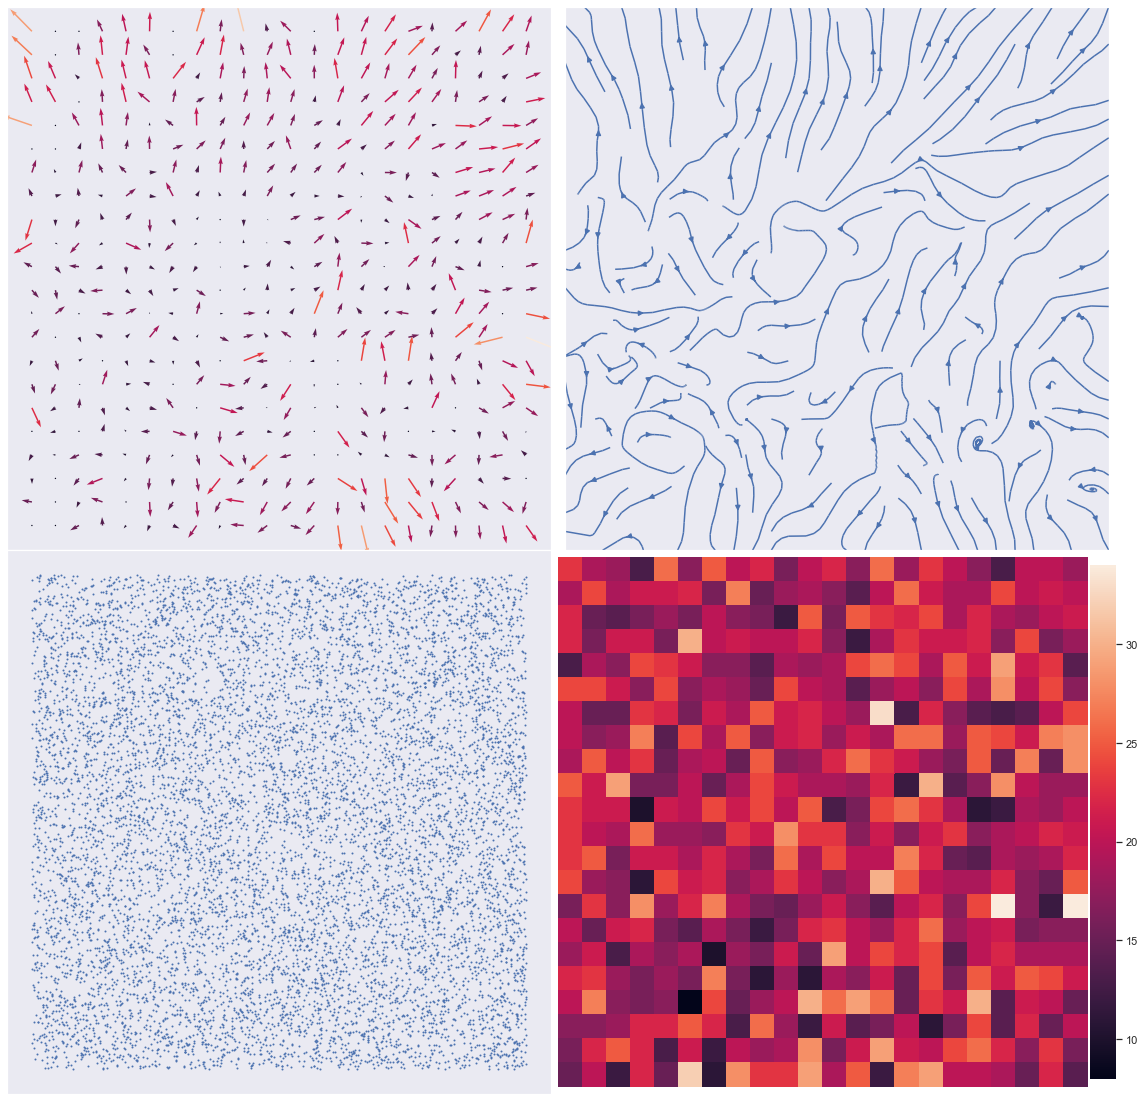

In [16]:
from math import floor
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

path = "../x64/Debug/Data/bak/"
csv = ".csv"
cell = "cellvalues_"
particles = "particles_"
timestep = 'timestep_'
av = 20
constants = 'constants_' + str(av) + csv
i = 'i'
j = 'j'
x = 'x'
y = 'y'
vx = 'vx'
vy = 'vy'

constants_av20 = pd.read_csv(path + constants)
num_timesteps = int(constants_av20['timesteps'])

if ((not len(particles_x.loc[0]) == num_timesteps) and (not len(particles_y.loc[0]) == num_timesteps) and (not len(particles_vx.loc[0]) == num_timesteps) and (not len(particles_vy.loc[0]) == num_timesteps)):
    # Loading particles
    print('Loading particles ..')
    filenames_particles = glob.glob('{}{}{}*_av20.csv'.format(path, particles, timestep))
    dfs = []
    for path in filenames_particles:
        df = pd.read_csv(path)
        dfs.append(df)
    
    x_columns = ['{}{}'.format(x, num) for num in range(0, len(filenames_particles))]
    y_columns = ['{}{}'.format(y, num) for num in range(0, len(filenames_particles))]
    vx_columns = ['{}{}'.format(vx, num) for num in range(0, len(filenames_particles))]
    vy_columns = ['{}{}'.format(vy, num) for num in range(0, len(filenames_particles))]
    
    particles_x = pd.DataFrame(columns=x_columns)
    particles_y = pd.DataFrame(columns=y_columns)
    particles_vx = pd.DataFrame(columns=vx_columns)
    particles_vy = pd.DataFrame(columns=vy_columns)

    it = 0
    for df in dfs:
        particles_x['{}{}'.format(x, it)] = df[x]
        particles_y['{}{}'.format(y, it)] = df[y]
        particles_vx['{}{}'.format(vx, it)] = df[vx]
        particles_vy['{}{}'.format(vy, it)] = df[vy]
        it += 1
    it = 0
    print('Particles loaded!\n')
    # Particles loaded
else: print('Particles already loaded.\n')

if (not len(timesteps) == num_timesteps):
    # Loading cells
    print('Loading cells')

    cell_dim = float(constants_av20['cell_dim'])

    filenames_cells = glob.glob('{}{}{}*_av20.csv'.format(path, cell, timestep))

    timesteps = []
    for path in filenames_cells:
        df = pd.read_csv(path)
        #df[[i,j]] = (df[[i,j]] + 1/2) * cell_dim
        timesteps.append(df)
    print('Cells loaded!\n')
    # Cells loaded
else: print('Cells already loaded.\n')

if ((not len(U)) and (not len(V)) and (not len(I)) and (not len(J))):
    # Preparing cell values
    print('Preparing cell values ..')
    width = float(constants_av20['x_max']) - float(constants_av20['x_0'])
    shown_cols = floor(width / cell_dim)
    height = float(constants_av20['y_max']) - float(constants_av20['y_0'])
    shown_rows = floor(height / cell_dim)

    df = df.loc[(df[i] >= 0) & (df[i] < shown_rows)]
    df = df.loc[(df[j] >= 0) & (df[j] < shown_cols)]

    array_i = np.arange(0, shown_rows)
    array_j = np.arange(0, shown_cols)
    I,J = np.meshgrid(array_i, array_j)

    U = []
    V = []
    for it in array_i:
        temp = df.loc[df[i] == it]
        u = np.array(temp[vx])
        U.append(u)
        v = np.array(temp[vy])
        V.append(v)
    U = np.array(U)
    V = np.array(V)
    print('Cell preparation complete!\n')
    # Cell preparation complete
else: print('Cell preparation already completed.\n')

if (not len(pivot)):
    # Load cell frequencies
    print('Loading cell frequencies ..')
    row = 'i'
    col = 'j'
    num = 'n'
    name_frequencies = 'cell_frequencies_av_' + str(av)
    average_particles = 'average_particles_per_cell'

    temp = pd.read_csv(path + name_frequencies + csv)
    temp = temp[temp[row] != temp[row].max()]
    temp = temp[temp[col] != temp[col].max()]
    pivot = temp.pivot(index = row, columns = col, values = num)
    print('Cell frequency loading complete!\n')
    # Frequency loading complete
else: print('Cell frequencies already loaded.\n')


# Plotting
#with (sns.plotting_context(sns.set())):
print('Plotting data ..')
fig = plt.figure(figsize=(20,20))
ax = [fig.add_subplot(2,2,i+1) for i in range(4)]

for a in ax:
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.set_aspect('equal')
    
fig.subplots_adjust(wspace=0, hspace=0)

color = np.sqrt(U**2 + V**2)
point_size = 1

ax[0].xaxis.set_ticks([])
ax[0].yaxis.set_ticks([])
ax[0].quiver(I, J, U, V, color, scale = 0.4)

ax[1].xaxis.set_ticks([])
ax[1].yaxis.set_ticks([])
ax[1].streamplot(I, J, U, V, ) # grid

ax[2].xaxis.set_ticks([])
ax[2].yaxis.set_ticks([])
ax[2].plot(particles_x['x0'], particles_y['y0'], "o", markersize = point_size)

ax[3].xaxis.set_ticks([])
ax[3].yaxis.set_ticks([])
#img = ax[3].imshow(pivot, cmap='hot')
#fig.colorbar(img, ax=ax[3], fraction=0.046, pad=0.005)
sns.heatmap(pivot, ax=ax[3], xticklabels = False, yticklabels = False, cbar_kws={"fraction": 0.046, "pad": 0.005})
#ax[3].xticks('')
#ax[3].yticks('')
ax[3].set_ylabel('')
ax[3].set_xlabel('')
#ax[1,1].imshow(pivot, cmap='hot')

#plt.savefig("Assets/timesteps.png")
#plt.close()
print('Data plotted!')

In [ ]:
from matplotlib import animation

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
color = np.sqrt(vx_evolution['vx0']**2 + vy_evolution['vy0']**2)
quiv = ax.quiver(grid_x, grid_y, vx_evolution['vx0'], vy_evolution['vy0'], color, scale = 0.4)

# initialization function: plot the background of each frame
def init():
    #quiv.set_data([], [], [], [])
    return quiv,

# animation function.  This is called sequentially
def animate(it):
    quiv.set_UVC(vx_evolution[vx + str(it)], vy_evolution[vy + str(it)])
    return quiv,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, #init_func=init,
                               frames=200, interval=20, blit=True)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

plt.show()

In [ ]:
from matplotlib import animation

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
color = np.sqrt(vx_evolution['vx0']**2 + vy_evolution['vy0']**2)
quiv = ax.quiver(grid_x, grid_y, vx_evolution['vx0'], vy_evolution['vy0'], color, scale = 0.4)

# initialization function: plot the background of each frame
def init():
    #quiv.set_data([], [], [], [])
    return quiv,

# animation function.  This is called sequentially
def animate(it):
    quiv.set_UVC(vx_evolution[vx + str(it)], vy_evolution[vy + str(it)])
    return quiv,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, #init_func=init,
                               frames=200, interval=20, blit=True)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

plt.show()

In [ ]:
x_columns = ['{}{}'.format(x, num) for num in range(0, len(filenames))]
y_columns = ['{}{}'.format(y, num) for num in range(0, len(filenames))]
vx_columns = ['{}{}'.format(vx, num) for num in range(0, len(filenames))]
vy_columns = ['{}{}'.format(vy, num) for num in range(0, len(filenames))]
    
x_evolution = pd.DataFrame(columns=x_columns)
y_evolution = pd.DataFrame(columns=y_columns)
vx_evolution = pd.DataFrame(columns=vx_columns)
vy_evolution = pd.DataFrame(columns=vy_columns)

it = 0
for df in dfs:
    x_evolution['{}{}'.format(x, it)] = df[i]
    y_evolution['{}{}'.format(y, it)] = df[j]
    vx_evolution['{}{}'.format(vx, it)] = df[vx]
    vy_evolution['{}{}'.format(vy, it)] = df[vy]
    it += 1

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

from math import floor
startPointX = 0
width = float(constants_av20['x_max']) - float(constants_av20['x_0'])
endPointX = floor(width / cell_dim)
startPointY = 0
height = float(constants_av20['y_max']) - float(constants_av20['y_0'])
endPointY = floor(height / cell_dim)

I, J = np.mgrid[startPointX:endPointX:1, startPointY:endPointY:1]
print(I)
print(J)
print(vx_evolution['vx0'])

In [ ]:
import numpy as np


w = 3
Y, X = np.mgrid[-w:w:100j, -w:w:100j]
U = -1 - X**2 + Y
V = 1 + X - Y**2
speed = np.sqrt(U**2 + V**2)

fig = plt.figure(figsize=(7, 9))
gs = gridspec.GridSpec(nrows=1, ncols=1)

#  Varying density along a streamline
ax0 = fig.add_subplot(gs[0, 0])
ax0.streamplot(X, Y, vx_evolution, vy_evolution, density=[0.5, 1])
ax0.set_title('Varying Density')

In [ ]:
vx_evolution.sum(axis = 0)

In [ ]:
vy_evolution.sum(axis = 0)

The velocity of a particle updates according to
\begin{equation}
\vect{v_{i}} \rightarrow \vect{V_c} + \matr{R}(\alpha)[\vect{v_i} - \vect{V_c}],
\end{equation}

where $\vect{v_{i}}$ is the velocity of the $i-th$ particle, $\vect{V_c}$ is the mean velocity of all particles belonging to cell $c$, specified by $i$'s position. The matrix

$$
R(\alpha) = 
\left[ \begin{array}{rr}
cos(\alpha) & -sin(\alpha) \\
sin(\alpha) & cos(\alpha) \\
\end{array}\right]
$$

is a simple 2d-rotation matrix. The angle $\alpha$ is uniformly sampled from the interval $[0, 2\pi)$ on a per-cell basis.[@malev1999]

<!--

CONSIDER THIS. SHOULD BECOME MAXWELL WHEN IMPLEMENTING COLLISION STEP TOO
After having implemented the streaming step and that other one: after time driftting, looks like this: (+velocity distribution = maxwell?)

### some equations to copy

$$
r(t + \Delta t) = r(t) + \Delta t \cdot v(t)
$$

## Converting to Word doc (others possible too, f.ex. .tex)

In [ ]:
# just do it manually, it works on anaconda env datascience

import subprocess
#automatic document conversion to markdown and then to word
#first convert the ipython notebook paper.ipynb to markdown
subprocess.run("jupyter nbconvert --to markdown thesis.ipynb --output-dir='./Generated'") #--output-dir='./Generated'
#next remove code
path = "./Generated/thesis.md"
with open(path, "r") as f:
    lines = f.readlines()
    idx = []
    idx_files = []
    for i, line in enumerate(lines):
        if (line.startswith("```")):
            idx.append(i)
        if ("thesis_files" in line):
            c = line.find("thesis_files")
            lines[i] = line[0:c] + "" + line[c:]

idx = sorted(idx, reverse=True) # reverse order so not deleting lines and then missing others
for current, previous in zip(idx[::2], idx[1::2]):
    print("Deleting {p}:{c}".format(p=previous, c=current+1))
    print('\n'.join(lines[previous:current+1]))
    del lines[previous:current+1]
    
with open(path, "w") as f:
    #f.write("\\newcommand{\matr}[1]\\textbf{#1}")
    #f.write("\\newcommand{\\vect}[1]{\\vec{#1}}")
    for line in lines:
        f.write("%s" % line)
#next convert markdown to ms word
conversion_tex = "pandoc -s ./Generated/thesis.md -o ./Generated/thesis.tex --filter pandoc-citeproc --bibliography=\"list.bib\" --csl=\"apa.csl\""
subprocess.run(conversion_tex)
conversion_pdf = "pandoc -s ./Generated/thesis.md -o ./Generated/thesis.pdf --filter pandoc-citeproc --bibliography=\"list.bib\" --csl=\"apa.csl\""
subprocess.run(conversion_pdf)
# LATEX TO DOCX pandoc -s math.tex -o example30.docx

## Equation Numbering jupyter extension
conda install -c conda-forge jupyter_contrib_nbextensions

jupyter contrib nbextension install --user

jupyter nbextension enable equation-numbering/main

### Turn equation numbering on/off

In [ ]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

### Renumber equations

In [ ]:
%%javascript
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

-->